In [86]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import Keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
train_data=pd.read_csv("/content/drive/MyDrive/homework/pageviews-20220101-20220823.csv",usecols=[1],engine = "python")
test_data = pd.read_csv("/content/drive/MyDrive/homework/pageviews-20210101-20210630.csv",usecols=[1],engine = "python")

# Devise a methodology or write code to predict the daily pageviews to this page from now until the middle of next year.

* Note that traffic to the page has weekly seasonality and a slight upwards trend
* Predict from 19/01/2023 to 30/06/2023

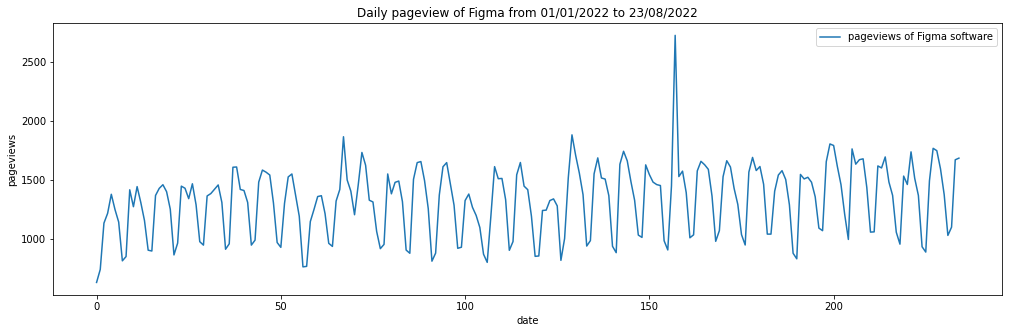

In [87]:
# 1. data visualisation from 01/01/2022 to 23/08/2022 as train dataset
plt.figure(figsize = (17, 5))
plt.plot(train_data, label = "pageviews of Figma software")
plt.xlabel("date")
plt.ylabel("pageviews")
plt.title("Daily pageview of Figma from 01/01/2022 to 23/08/2022")
plt.legend()
plt.show()

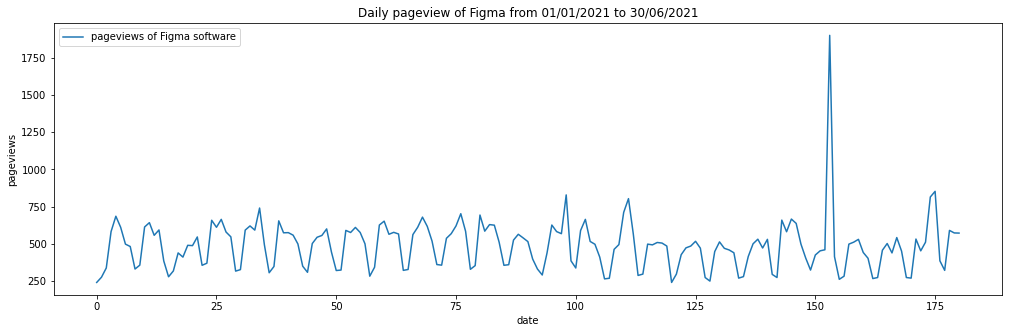

In [88]:
# 2. data visualisation from 01/01/2021 to 30/06/2021 as test dataset
plt.figure(figsize = (17, 5))
plt.plot(test_data, label = "pageviews of Figma software")
plt.xlabel("date")
plt.ylabel("pageviews")
plt.title("Daily pageview of Figma from 01/01/2021 to 30/06/2021")
plt.legend()
plt.show()
# there is a period of strange data which is a outlier

In [89]:
# Deep learning method: LSTM
# split train set to trainset and validation set

# convert pandas data frame in numpy array of float.
data_np = train_data.values.astype("float32")
test_np = test_data.values.astype("float32")

# normalize data with min max normalization - with same scale and contain all the patterns in case other pattern dominate!
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data_np)
testset = normalizer.fit_transform(test_np)

# Using 70% of data for training, 30% for validation.
TRAINING_PERC = 0.70

train_size = int(len(dataset) * TRAINING_PERC)
val_size = len(dataset) - train_size
train, val = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Total dates of input set: " + str((len(train_data))))
print("Number of samples training set: " + str((len(train))))
print("Number of samples validation set: " + str((len(val))))

Total dates of input set: 235
Number of samples training set: 164
Number of samples validation set: 71


In [90]:
# create data with n*7*1 as input of NN.
def create_dataset(dataset, window_size = 1):
    data_x, data_y, data_mean = [], [],[]
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        
        data_x.append(sample)
        # the 8th date as a lable
        data_y.append(dataset[i + window_size, 0])

    for i in range(0,len(dataset),window_size):
        m = np.mean(dataset[i:(i + window_size), 0])
        data_mean.append(m)
    return(np.array(data_x), np.array(data_y), np.array(data_mean))

# Create test and training sets for regression with window size 7.
# reduce data length in case of gradient vanishing!
window_size = 7
train_X, train_Y, train_mean = create_dataset(train, window_size)
val_X, val_Y, val_mean = create_dataset(val, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))

test_X, test_Y, test_mean = create_dataset(testset, window_size)
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

week_mean = np.hstack((train_mean, val_mean))
print("Shape of training inputs: " + str((train_X.shape)))
print("Shape of training inputs: " + str((val_X.shape)))
print("Shape of training labels: " + str((train_Y.shape)))
print("Shape of training inputs: " + str((test_X.shape)))
print("Shape of mean: " + str((week_mean.shape)))

Shape of training inputs: (156, 7, 1)
Shape of training inputs: (63, 7, 1)
Shape of training labels: (156,)
Shape of training inputs: (173, 7, 1)
Shape of mean: (35,)


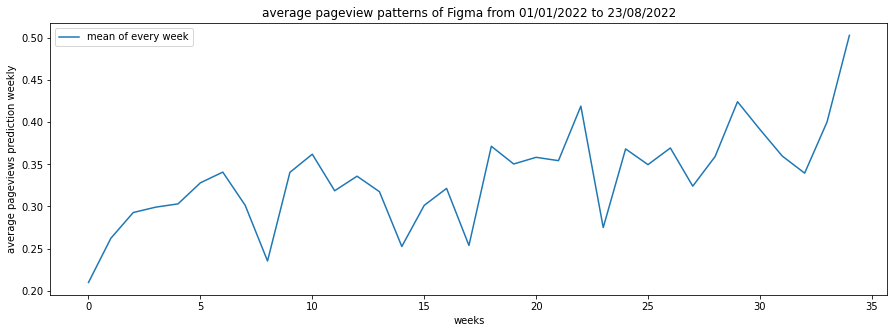

In [91]:
# Cyclical pattern observation of train_data
week_mean = np.hstack((train_mean, val_mean))
plt.figure(figsize = (15, 5))
plt.plot(week_mean, label = "mean of every week")
plt.xlabel("weeks")
plt.ylabel("average pageviews prediction weekly")
plt.title("average pageview patterns of Figma from 01/01/2022 to 23/08/2022")
plt.legend()
plt.show()

In [92]:
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
batch_size = 32
rnn = Sequential()    
# use 7 data points to output the 8th data
rnn.add(Bidirectional(LSTM(32, return_sequences=True)))
rnn.add(Bidirectional(LSTM(32)))
rnn.add(Dense(64, activation='relu'))
rnn.add(Dense(64, activation='relu'))
rnn.add(Dense(1))
rnn.compile(loss = "mean_squared_error",  optimizer = Adam(learning_rate=0.001), metrics = ['mse'])
earlystop = EarlyStopping(monitor='val_mse', patience=100)
history = rnn.fit(train_X, train_Y, epochs=150, batch_size=batch_size,verbose=False, validation_data=(val_X, val_Y), callbacks = earlystop)

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


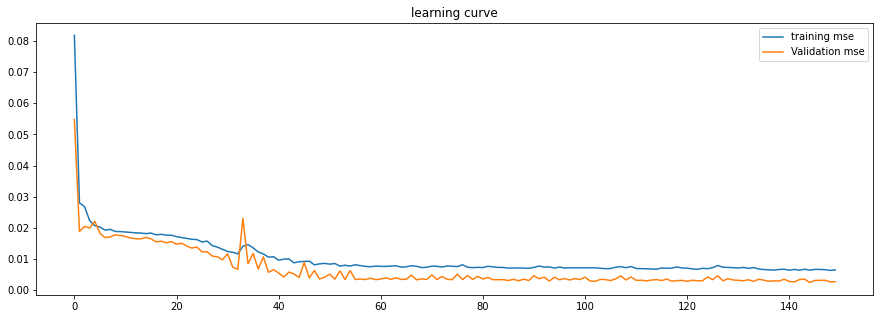

In [93]:
print(history.history.keys())
plt.figure(figsize = (15, 5))
plt.plot(history.history['mse'], label = "training mse")
plt.plot(history.history['val_mse'], label = "Validation mse")
plt.title("learning curve")
plt.legend()
plt.show()

In [94]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(Y, model.predict(X)))
    return score, pred

mse_train, train_predict = get_predict_and_score(rnn, train_X, train_Y)
mse_val, val_predict = get_predict_and_score(rnn, val_X, val_Y)
mse_test, test_predict = get_predict_and_score(rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Validation data error: %.2f MSE" % mse_val)
print("test data error: %.2f MSE" % mse_test)

6/6 [==============================] - 0s 4ms/step
Training data error: 0.08 MSE
Validation data error: 0.05 MSE
test data error: 0.11 MSE


In [95]:
# Training predictions.
print(train_predict.shape)
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# validation predictions.
val_predictions = np.empty_like(dataset)
val_predictions[:, :] = np.nan
val_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = val_predict

# Test predictions
test_predictions = np.empty_like(testset)
test_predictions[:, :] = np.nan
test_predictions[window_size:len(test_predict) + window_size, :] = test_predict

print(len(train))

(156, 1)
164


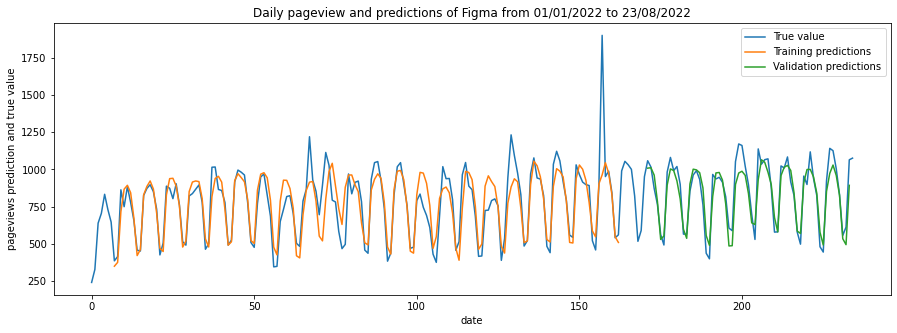

In [96]:
# Visualization of the train and validation predictions vs true value. Values fluctuated from 500 to 1000
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True value")
plt.plot(train_predictions, label = "Training predictions")
plt.plot(val_predictions, label = "Validation predictions")
plt.xlabel("date")
plt.ylabel("pageviews prediction and true value")
plt.title("Daily pageview and predictions of Figma from 01/01/2022 to 23/08/2022")
plt.legend()
plt.show()

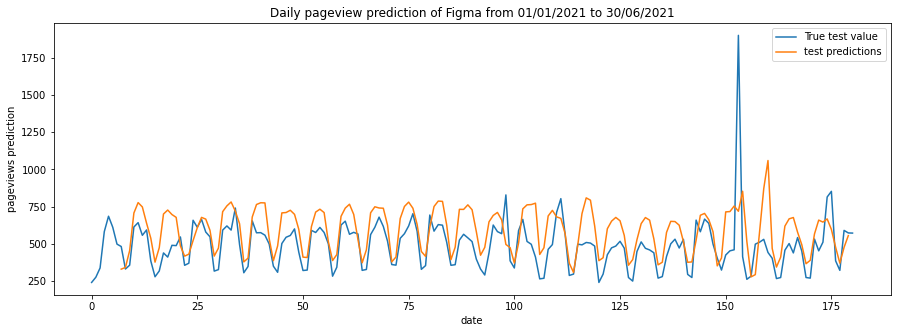

In [97]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(testset), label = "True test value")
plt.plot(test_predictions, label = "test predictions")
plt.xlabel("date")
plt.ylabel("pageviews prediction")
plt.title("Daily pageview prediction of Figma from 01/01/2021 to 30/06/2021")
plt.legend()
plt.show()

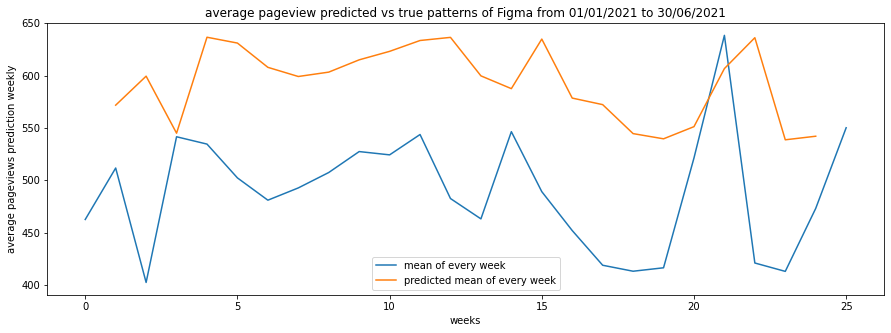

In [98]:
# Cyclical pattern observation of test_data
test_mean = []
for i in range(0,len(test_np),window_size):
        m = np.mean(test_np[i:(i + window_size), 0])
        test_mean.append(m)

# Cyclical pattern prediction of test_data
pred_mean = []
for i in range(0,len(test_predictions),window_size):
        m = np.mean(test_predictions[i:(i + window_size), 0])
        pred_mean.append(m)
plt.figure(figsize = (15, 5))
plt.plot(test_mean, label = "mean of every week")
plt.plot(pred_mean, label = "predicted mean of every week")
plt.xlabel("weeks")
plt.ylabel("average pageviews prediction weekly")
plt.title("average pageview predicted vs true patterns of Figma from 01/01/2021 to 30/06/2021")
plt.legend()
plt.show()

In [99]:
# # Final step: predict from 01/01/2023 to middle of the 2023 - 180 days
# each prediction will shift for 7 days - so we need predict 310 times 
# so that the data can be predict and shift from the last 7 days before 23/08/2022 to 30/06/2023
arr = val_X[-1]
arr_1 = np.reshape(arr, (1, 7, 1))
# last 7 dates to predict!
for j in range(310):
  if arr_1.shape[0] != 1:
    pred = rnn.predict(np.reshape(arr_1[-1,:,:],(1,7,1)), verbose=False) 
  else:
    pred = rnn.predict(arr_1, verbose = False)
  arr = np.vstack((arr, pred))
  mao = arr[-7:]
  mao = np.reshape(mao, (1,7,1))
  arr_1 = np.vstack((arr_1, mao))


In [100]:
new_predict = arr[-180:]
print(new_predict.shape)
new_predict = normalizer.inverse_transform(new_predict)

(180, 1)


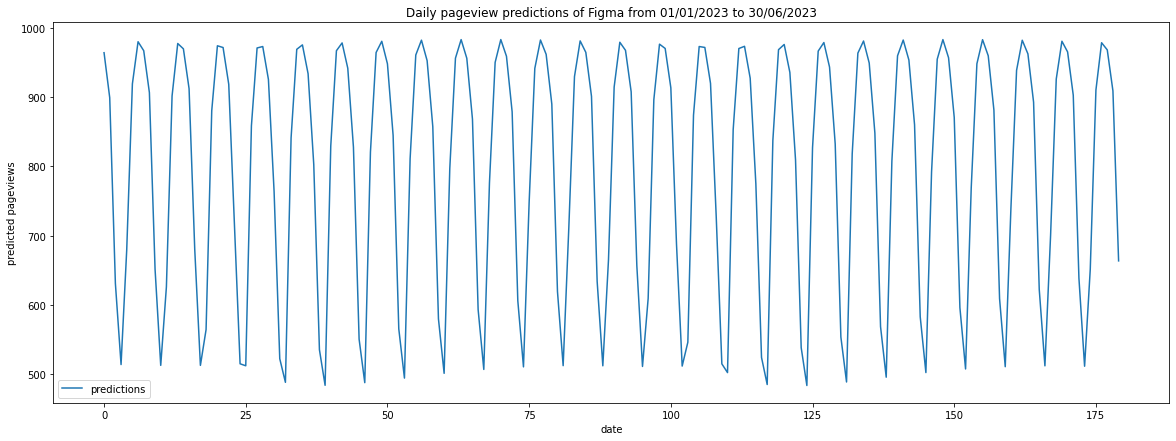

In [101]:
plt.figure(figsize = (20, 7))
plt.plot(new_predict, label = "predictions")
plt.xlabel("date")
plt.ylabel("predicted pageviews")
plt.title("Daily pageview predictions of Figma from 01/01/2023 to 30/06/2023")
plt.legend()
plt.show()

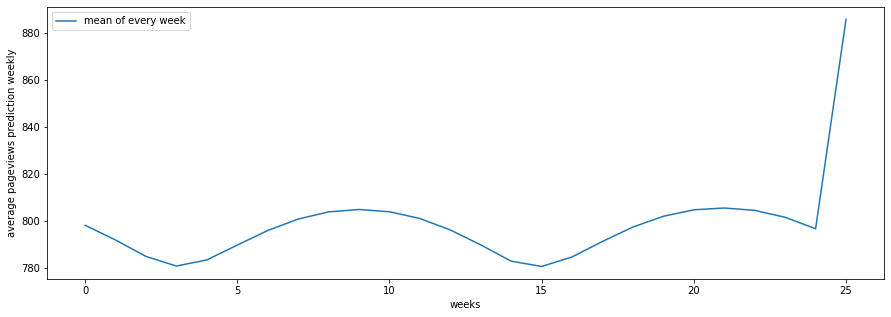

In [102]:
# Cyclical pattern prediction of test_data: 
new_mean = []
for i in range(0,len(new_predict),window_size):
        m = np.mean(new_predict[i:(i + window_size), 0])
        new_mean.append(m)

plt.figure(figsize = (15, 5))
plt.plot(new_mean, label = "mean of every week")
plt.xlabel("weeks")
plt.ylabel("average pageviews prediction weekly")
plt.legend()
plt.show()